In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print("Using torch", torch.__version__)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # prefer gpu
print("Device", device) 

Using torch 2.0.1
Device cpu


In [3]:
class XORDataset(data.Dataset):
    def __init__(self, size, std=0.1, device=device):
        """Make a random XOR data set.

        Args:
            size: Number of data points we want to generate
            std: Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)

        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        # Move data to GPU if relevant
        self.data = data.to(device)
        self.label = label.to(device)

    def __len__(self):
        # Number of data points we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

    def toNumpy(self):
        return (self.data.cpu().numpy(), self.label.cpu().numpy()) # must be on cpu to convert to numpy

Size of dataset: 200
Data point 0: (tensor([ 1.0527, -0.0487]), tensor(1))


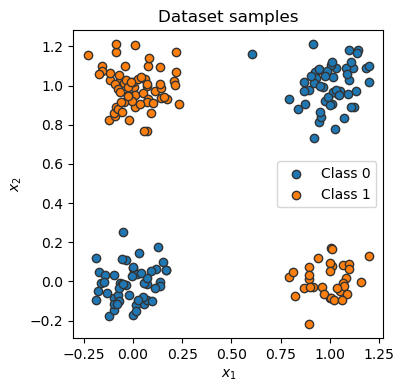

In [4]:
def visualize_binary_samples(dataset):
    """visualize a data set with binary labels.

    Args:
        data: the data set as, e.g., generated by XORDataset
    """
    (data,label) = dataset.toNumpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])
visualize_binary_samples(dataset)
plt.show()

In [5]:
class SimpleClassifier(nn.Module):
    def __init__(self, src, tg, depth, width, device=device):
        """Make a convolutional neural network. Last layer uses the identity transfer function, the rest use the tanh.

        Args:
            src: The number of input nodes
            tg: The number of output nodes
            depth: The number of hidden layers
            width: The width of the hidden layers
        """
        super().__init__()

        self.enc_sizes = [src, tg, depth, width]

        # Define the list of layers for the neural network
        if depth == 0:
            layers = [nn.Linear(src, tg)]
        else:
            layers = [nn.Linear(src, width)]  # Input layer

            # Hidden layers
            for _ in range(depth-1): # depth-1 because we already added one layer
                layers.append(nn.Linear(width, width))
                
            layers.append(nn.Linear(width,tg)) # output layer


        # Constructs the neural network model using nn.Sequential. 
        # The nn.Sequential container is initialized with the layers defined in functionLst. 
        # The * operator is used to unpack the list of layers as arguments to nn.Sequential.
        self.model = nn.Sequential(*layers)

        # Move data to GPU if relevant
        self.model.to(device)

    # defines the forward pass of the neural network.
    def forward(self, x):
        x = self.model(x)
        x = x.squeeze(dim=1) # flat

        return x


def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    """Train a model.

    Args:
        model: The model to train
        optimizer: The optimizer to use
        data_loader: The function to load the data
        loss_module: The function to evaluate the loss function
        num_epochs: The number of epochs to train
    """
    # Set model to train mode
    model.train()

    # Training loop
    for epoch in range(num_epochs):
        for data_inputs, data_labels in data_loader:
            # Step 1: Run the model on the input data
            preds = model(data_inputs)
            #preds = preds.squeeze(dim=1)  # Output is [Batch size, 1], but we want [Batch size]

            # Step 2: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            # Step 3: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            loss.backward()

            # Step 4: Update the parameters
            optimizer.step()


def eval_model(model, data_loader): # added loss_module to arguments
    """Evaluate a model.

    Args:
        model: A (trained) model
        data_loader: The function to load the data
    """
    model.eval()  # Set model to eval mode
    true_preds, num_preds = 0.0, 0.0

    with torch.no_grad():  # Deactivate gradients for the following code

        for data_inputs, data_labels in data_loader:
            preds = model(data_inputs)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    return acc

In [6]:
# counts the parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
loss_module = nn.BCEWithLogitsLoss()
train_dataset = XORDataset(size=1000)
batch_size = 10
lr = 0.1
num_epochs = 200

train_data_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

### 1.2 Update below

In [8]:
# Setup a feed-forward network with variable width and depth
repeatitions = 3


acc_depth = [] # save accuracies for each depth
loss_mean_std = []  # Save mean and standard deviation of loss for each depth


for depth in range(4):
    loss_depth = []  # Save mean and standard deviation of loss for each width
    acc_width = [] # save accuracies for each width

    for width in range(1,4):      
        acc_experiment = []

        for _ in range(repeatitions):

            model = SimpleClassifier(src=2, tg=1, depth=depth, width=width) # create a new model with the given depth and width
            optimizer = torch.optim.SGD(model.parameters(), lr=lr) # create a new optimizer (SGD
            train_model(model, optimizer, train_data_loader, loss_module, num_epochs=num_epochs) # train the model
            acc_experiment.append(eval_model(model, test_data_loader)) # evaluate the model on the test set
        
        # count the number of parameters
        params = count_parameters(model) 
        print (f"d={depth}, w={width}, #params = {params}")
        acc_avg = sum(acc_experiment) / len(acc_experiment) 
        loss_width = [1-acc.item() for acc in acc_experiment] # calculate the loss for each experiment
        mean = np.mean(loss_width)
        std = np.std(loss_width)
        
        print(f"Mean: {mean}, Std: {std}, acc: {acc_avg} \n")

        acc_width.append(acc_avg)
        
       
    acc_depth.append(acc_width)

d=0, w=1, #params = 3
Mean: 0.5940000116825104, Std: 0.133026308555311, acc: 0.4059999883174896 

d=0, w=2, #params = 3
Mean: 0.6059999962647756, Std: 0.0584465603310449, acc: 0.39400002360343933 

d=0, w=3, #params = 3
Mean: 0.5893333405256271, Std: 0.11785112317328317, acc: 0.41066667437553406 

d=1, w=1, #params = 5
Mean: 0.5386666754881541, Std: 0.046197638317074075, acc: 0.461333304643631 

d=1, w=2, #params = 9
Mean: 0.5166666706403097, Std: 0.025315770343774354, acc: 0.4833333492279053 

d=1, w=3, #params = 13
Mean: 0.49800001581509906, Std: 0.005656851664485671, acc: 0.5020000338554382 

d=2, w=1, #params = 7
Mean: 0.48000000913937885, Std: 0.15703077042185415, acc: 0.5199999809265137 

d=2, w=2, #params = 15
Mean: 0.4633333484331767, Std: 0.060339774502763, acc: 0.5366666316986084 

d=2, w=3, #params = 25
Mean: 0.4920000036557515, Std: 0.019799001899124105, acc: 0.5079999566078186 



In [ ]:
# Plot the results
plt.figure()
d0 = acc_depth[0]
d1 = acc_depth[1]
d2 = acc_depth[2]
d3 = acc_depth[3]

plt.plot(range(1,4,1), d0, label="Depth=0")
plt.plot(range(1,4,1), d1, label="Depth=1")
plt.plot(range(1,4,1), d2, label="Depth=2")
plt.plot(range(1,4,1), d3, label="Depth=3")

# Adding labels and title
plt.xlabel('Width of hidden layers')
plt.ylabel('Accuracy')
plt.title('Accuracy of the model for different depths and widths')

plt.xticks(range(1, len(d0) + 1))

# Adding legend
plt.legend()